In [51]:
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
import numpy as np

from tqdm import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [52]:
gamma = 0.99
lam = 0.95
clip_epsilon = 0.2
learning_rate = 3e-4
epochs = 10
policy_epochs = 4
value_epochs = 4
batch_size = 64
max_steps = 200
update_interval = 1000

In [53]:
class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(ActorCritic, self).__init__()
        self.actor = nn.Sequential(
            nn.Linear(state_dim, 64),
            nn.ReLU(),
            nn.Linear(64, action_dim),
        )
        self.critic = nn.Sequential(
            nn.Linear(state_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x, action=None):
        action_probs = self.actor(x)
        dist = Categorical(logits=action_probs)
        
        if action is None:
            action = dist.sample()
            
        log_p = F.log_softmax(action_probs, dim=-1).gather(-1, action.unsqueeze(-1)).squeeze(-1)
        
        value = self.critic(x)
        
        return action, log_p, value, dist.entropy()

In [54]:
def compute_gae(done, rewards, values, next_values, gamma=0.99, lambda_=0.95):
    assert len(values) == len(next_values) == len(rewards) == len(done)

    advantages = torch.zeros(done.shape[0], dtype=torch.float32)
    returns = torch.zeros(done.shape[0], dtype=torch.float32)
    last_advantage = 0
    last_return = 0

    for t in reversed(range(done.shape[0])):
        mask = 1.0 - done[t]
        last_value = next_values[t] * mask
        last_advantage = last_advantage * mask
        last_return = last_return * mask

        delta = rewards[t] + gamma * last_value - values[t]
        last_advantage = delta + gamma * lambda_ * last_advantage
        last_return = rewards[t] + gamma * last_return

        advantages[t] = last_advantage
        returns[t] = last_return

    return advantages, returns

In [55]:
def collect_trajectories(env, model, n_steps):

    states, actions, rewards, log_ps, state_values, dones = [], [], [], [], [], []

    state, _ = env.reset()
    

    total_reward = 0
    step_count = 0

    for _ in range(n_steps):
        state = torch.FloatTensor(state)
        action, log_p, state_value, entropy = model(state)
        next_state, reward, terminated, truncated, _ = env.step(action.item())
        done = terminated or truncated

        states.append(state)
        actions.append(action)
        rewards.append(reward)
        log_ps.append(log_p)
        state_values.append(state_value)
        dones.append(done)

        state = next_state
        total_reward += reward
        step_count += 1

        if done:
            state, _ = env.reset()
            
    next_value = model.critic(torch.FloatTensor(next_state).unsqueeze(0)).squeeze(0)
    
    states = torch.stack(states)
    actions = torch.LongTensor(actions)
    rewards = torch.LongTensor(rewards)
    state_values = torch.FloatTensor(state_values)
    dones = torch.LongTensor(dones)
    next_state_values = torch.concatenate((state_values[1:], next_value))
    
    
    advantages, returns = compute_gae(dones, rewards, state_values, next_state_values)
         
    # Normalize advantages
    advantages = torch.FloatTensor(advantages)
    returns = advantages + torch.FloatTensor(state_values)
            
    trajectories = {
        "states" : states.detach(),
        "actions" : actions.detach(),
        "rewards" : rewards.detach(),
        "dones" : dones.detach(),
        "log_ps" : torch.stack(log_ps).detach(),
        "state_values": state_values.detach(),
        "next_state_values": next_state_values.detach(),
        "returns" : returns.detach(),
        "advantages" : advantages.detach(),
    }
    
    return trajectories


# trajectories = collect_trajectories(env, model, n_steps=128)

# for key in trajectories:
#     print(key, trajectories[key].shape)

In [56]:
def shufffle_trajectory(trajectories):
    length = trajectories['states'].shape[0]
    permutation = torch.randperm(length)

    shuffled_trajectories = {key: tensor[permutation] for key, tensor in trajectories.items()}
    return shuffled_trajectories

# shuffled_trajectories = shufffle_trajectory(trajectories)

In [57]:
def ppo_optimization(trajectories, model, optimizer, epochs, batch_size):
    
    model.train()
    
    traj_states = trajectories["states"]
    traj_actions = trajectories["actions"]
    traj_log_ps = trajectories["log_ps"]
    traj_returns = trajectories["returns"]  
    traj_advantages = trajectories["advantages"]


    len_trajectory = traj_states.shape[0]

    for epoch in range(1, epochs+1):
        for i in range(len_trajectory // batch_size):
            state = traj_states[batch_size*i:batch_size*(i+1)]
            action = traj_actions[batch_size*i:batch_size*(i+1)]
            log_p = traj_log_ps[batch_size*i:batch_size*(i+1)]
            return_ = traj_returns[batch_size*i:batch_size*(i+1)]
            advantage = traj_advantages[batch_size*i:batch_size*(i+1)]
            
            new_action, new_log_p, new_state_value, entropy = model(state, action)
            assert(new_action == action).all()
            
            
            advantage = (advantage - advantage.mean()) / (advantage.std() + 1e-8)
                    
            new_log_p, log_p, advantage = new_log_p.reshape(-1), log_p.reshape(-1), advantage.reshape(-1)
            
            ratio = torch.exp(new_log_p - log_p.detach())
            surr1 = ratio * advantage
            surr2 = torch.clamp(ratio, 1-0.2, 1+0.2) * advantage
            policy_loss = - torch.min(surr1, surr2).mean()
            
            
            return_, new_state_value = return_.reshape(-1), new_state_value.reshape(-1)

            value_loss = ((return_ - new_state_value)**2).mean()

            loss = policy_loss - 2e-7*entropy.mean() + 0.5*value_loss

            optimizer.zero_grad()
            loss.backward()
            clip_factor = torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
            optimizer.step()
            
# ppo_optimization(trajectories, model, optimizer, epochs=1, batch_size=5)

In [58]:
def evaluate(env, model):
    model.eval()

    state, _ = env.reset()
        
    total_reward = 0
    step_count = 0

    while True:
        state = torch.FloatTensor(state)
        with torch.no_grad():
            action, log_p, state_value, entropy = model(state)
        next_state, reward, terminated, truncated, _ = env.step(action.item())
        done = terminated or truncated

        state = next_state
        total_reward += reward
        step_count += 1

        if done:
            break
        
    return step_count

In [64]:
env = gym.make("CartPole-v1")
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

model = ActorCritic(state_dim, action_dim)
optimizer = optim.AdamW(model.parameters(), lr=0.01)

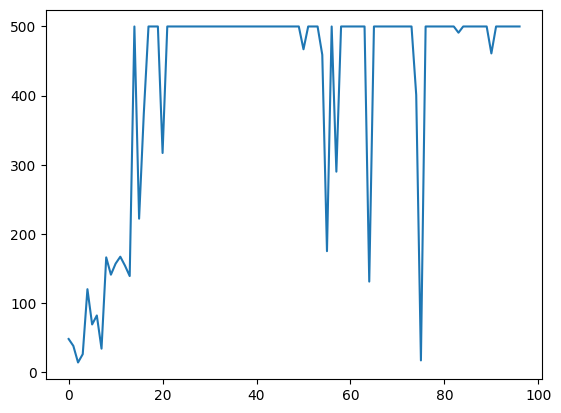

Reward: 500:  97%|█████████▋| 97/100 [00:34<00:01,  2.78it/s]


KeyboardInterrupt: 

In [65]:
rewards = []

tqdm_epochs = tqdm(range(100))
for epochs in tqdm_epochs:
    
    trajectory = collect_trajectories(env, model, n_steps=1024)
    shuffled_trajectory = shufffle_trajectory(trajectory)
    ppo_optimization(shuffled_trajectory, model, optimizer, epochs=5, batch_size=256)
    
    final_reward = evaluate(env, model)
    rewards.append(final_reward)
    
    tqdm_epochs.set_description(f'Reward: {final_reward}')
    
    clear_output(True)
    plt.plot(rewards)
    plt.show()